In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
def imshow(img):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.axis('off')
    ax.imshow(img, cmap='gray')

In [69]:
def render_images(images):
    for image_name, image in images:
        plt.figure(figsize=(7,7))
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.title(image_name)
        plt.show()
    pass

In [120]:
def distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

# def preprocess(im):
#     # MAKE FINE BINARY IMAGE
#     gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#     blur = cv2.GaussianBlur(gray, (23,23), 0)
# #     thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
#     thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
#     thresh = cv2.erode(thresh, np.ones((10,10)), iterations=1)
#     return thresh
def preprocess(im):
    # MAKE FINE BINARY IMAGE
    hue = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    low = (0, 0, 0)
    high = (180, 20, 255)
    mask = cv2.inRange(hue, low, high) != 255
    
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    gray[mask] = 0
    return gray

def get9reflections(im):
    # MAKE ALL CONTOURS CLOSED
    result = np.zeros_like(im)
    y = im.shape[0]
    x = im.shape[1]
    im_refx = im[::,::-1]
    middle_layer = np.hstack((im_refx, im))
    middle_layer = np.hstack((middle_layer, im_refx))
    result = np.vstack((middle_layer[::-1,::], middle_layer))
    result = np.vstack((result, middle_layer[::-1,::]))
    return result

def getContours(im):
    # APPROXIMATE CLOSED CONTOURS WITH FILLED POLYGONS
    result = np.zeros_like(im)
    y = im.shape[0]
    x = im.shape[1]
    contours,_ = cv2.findContours(im, 1, 2)
    for cnt in contours:
        peri = cv2.arcLength(cnt, closed=True)
        area = cv2.contourArea(cnt)
        too_big = (peri > 0.95*2*(x+y)) or (area > 0.95*x*y) 
        if not too_big:
            result = cv2.drawContours(result, [cnt], 0,  255, thickness=20)
    return result

def cutCenter(im):
    # ONLY AFTER get9reflections
    y = int(im.shape[0]/3)
    x = int(im.shape[1]/3)
    result = im[y:2*y, x:2*x]
    return result


def getRectMask(im):
    # SELECT ONLY SHAPES OF APPROPRIATE SIZE
    result = np.zeros_like(im)
    y = im.shape[0]
    x = im.shape[1]
    corners = []
    contours, _ = cv2.findContours(im, 1, 2)
    for cnt in contours:
        peri = cv2.arcLength(cnt, closed=True)
        area = cv2.contourArea(cnt)
        too_small = (peri < (x+y)/4000) or (area < x*y/15)
        too_big = (peri > 0.95*2*(x+y)) or (area > 0.95*x*y) 
        if (not too_small) and (not too_big):
            approx = cv2.approxPolyDP(cnt, 0.05*peri, True)
            if len(approx) == 4:
                result = cv2.fillPoly(result, [approx], 255)
                corners.append(approx)
                return result, corners


# Taken from:
# https://levelup.gitconnected.com/solving-a-sudoku-puzzle-using-deep-learning-and-backtracking-algorithm-c6cef475ae3
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.where(pts.sum(axis=1).sum(axis=1) == min(pts.sum(axis=1).sum(axis=1)))]
    rect[2] = pts[np.where(pts.sum(axis=1).sum(axis=1) == max(pts.sum(axis=1).sum(axis=1)))]
    
    diff = np.diff(pts, axis = 1)
    rect[3] = pts[np.where((pts[:,0,0] - pts[:,0,1]) == max((pts[:,0,0] - pts[:,0,1])))]
    rect[1] = pts[np.where((pts[:,0,0] - pts[:,0,1]) == min((pts[:,0,0] - pts[:,0,1])))]
    
    return rect

def adjustPerspective(image, pts):
    pts = np.array(pts)
    rect = order_points(pts)
    (bl, br, tr, tl) = rect

    widthA = np.sqrt(((br[0] - bl[0])**2) + ((br[1] - bl[1])**2))
    widthB = np.sqrt(((tr[0] - tl[0])**2) + ((tr[1] - tl[1])**2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0])**2) + ((tr[1] - br[1])**2))
    heightB = np.sqrt(((tl[0] - bl[0])**2) + ((tl[1] - bl[1])**2))
    maxHeight = max(int(heightA), int(heightB))
    
    
    if maxWidth > maxHeight: maxWidth, maxHeight = maxHeight, maxWidth
    dst = np.array([[0, 0], [0, maxHeight - 1],[maxWidth - 1, maxHeight - 1], [maxWidth - 1, 0]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def predict_image(image: np.ndarray) -> (np.ndarray, list):
    prep = preprocess(image)
    mask = get9reflections(prep)
    mask = getContours(mask)
    mask = cutCenter(mask)
    try:
        mask, corners = getRectMask(mask)
        applied_mask = cv2.bitwise_and(mask, prep)
        wrap = adjustPerspective(applied_mask, corners[0])
        wrap = cv2.adaptiveThreshold(wrap, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 7)
        return wrap
    except: return mask

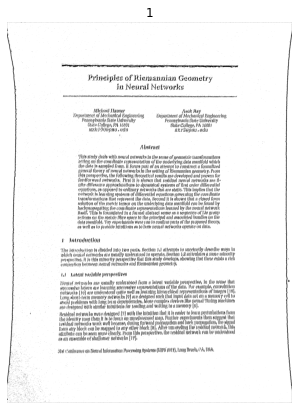

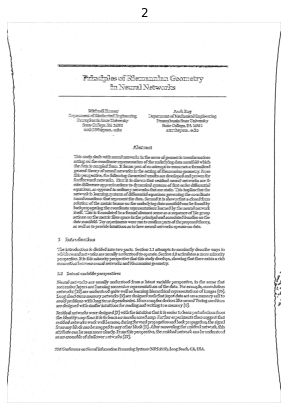

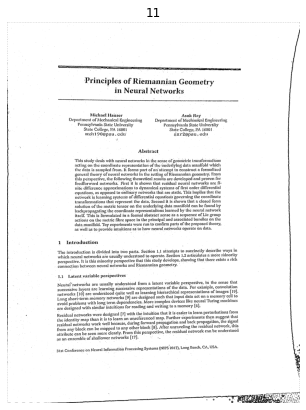

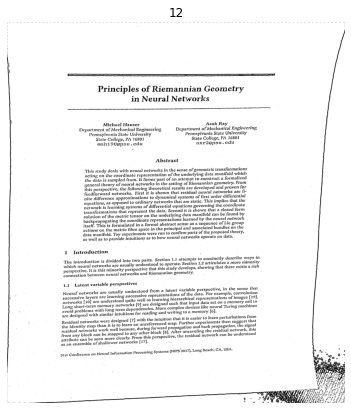

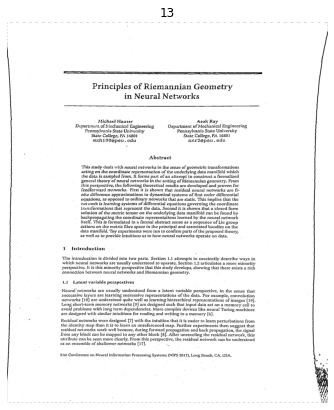

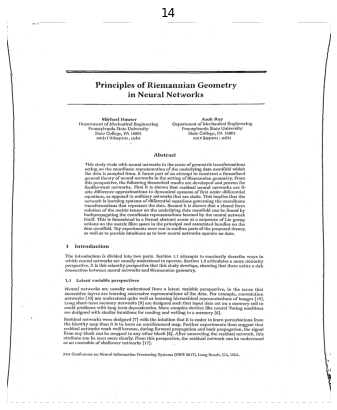

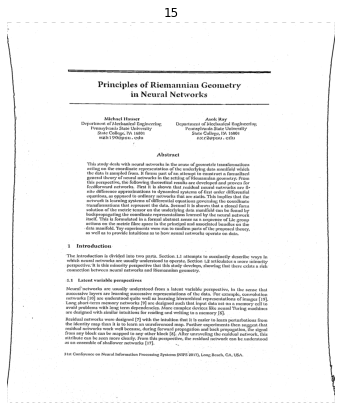

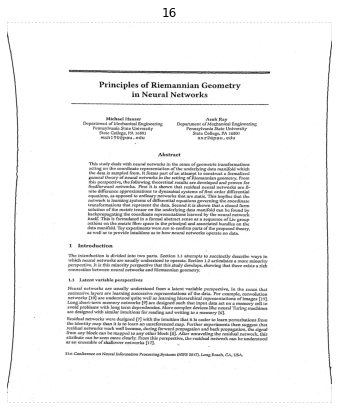

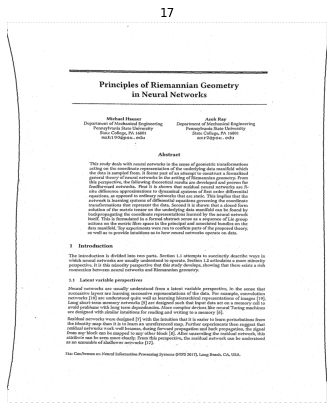

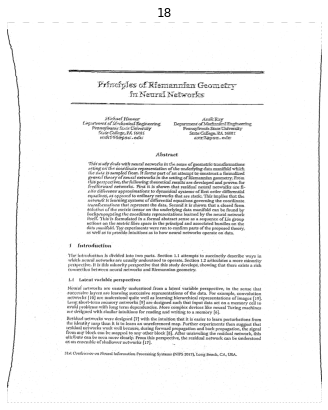

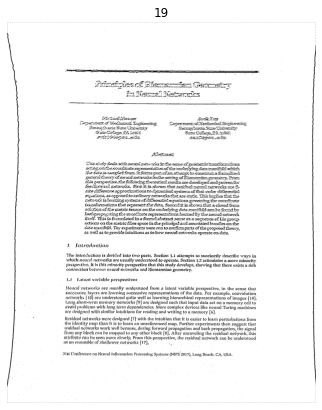

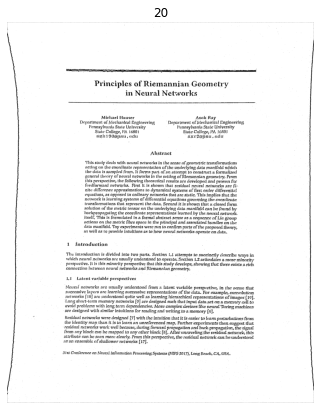

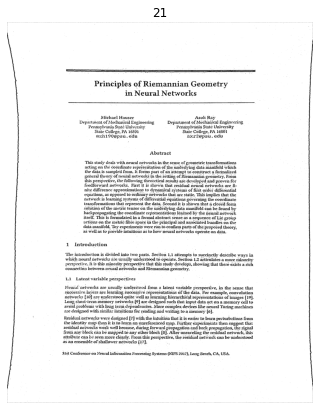

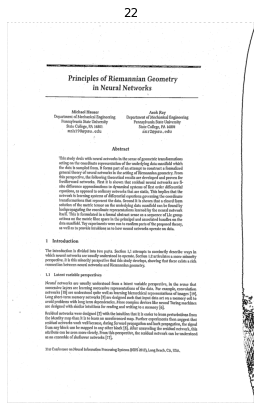

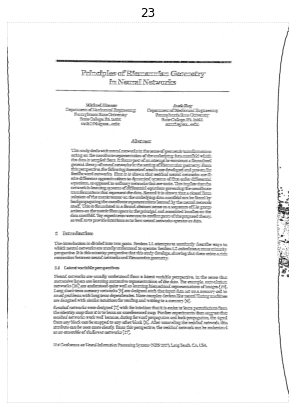

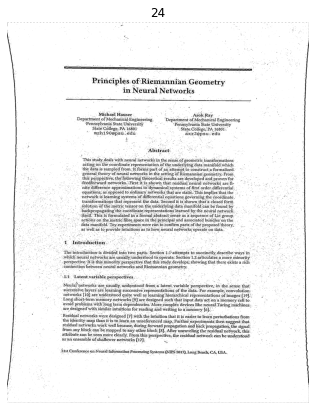

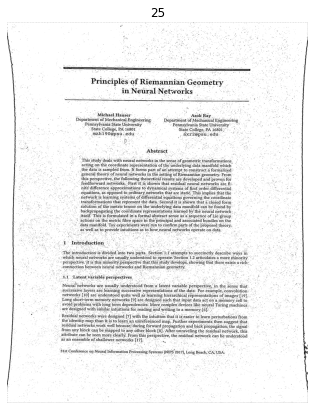

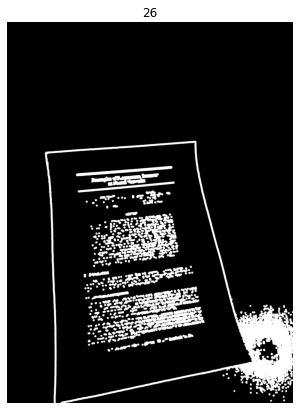

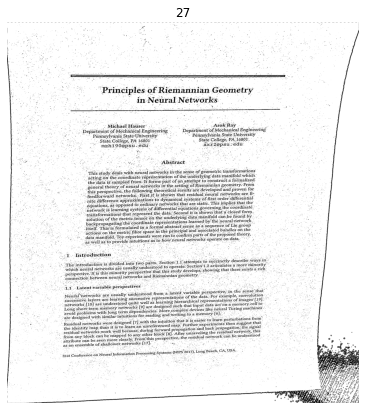

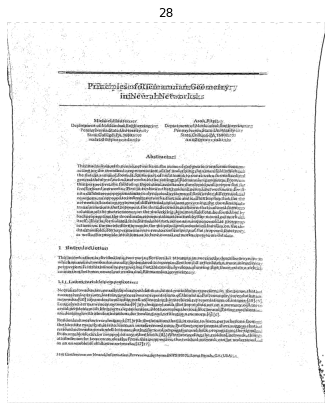

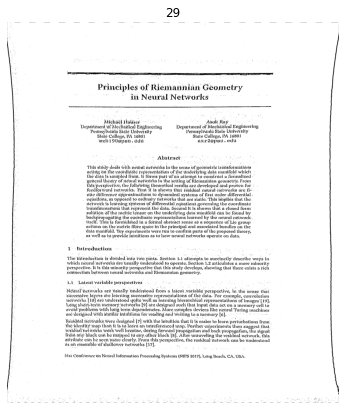

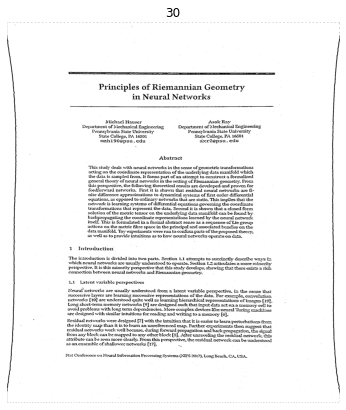

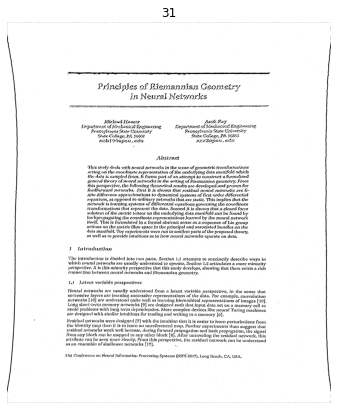

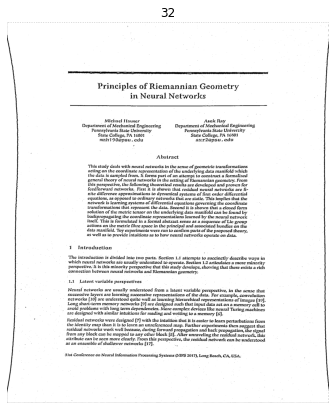

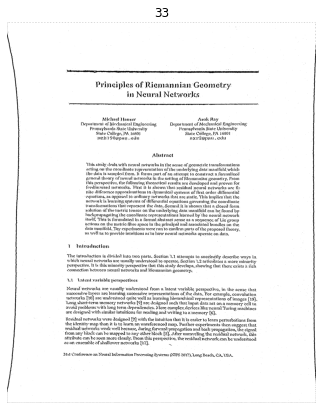

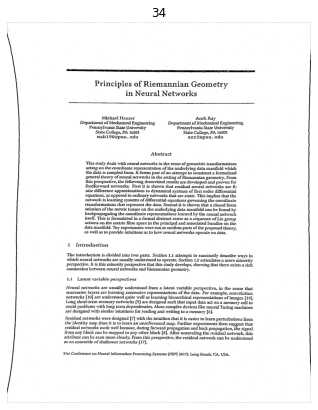

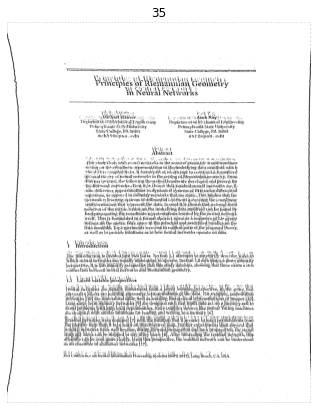

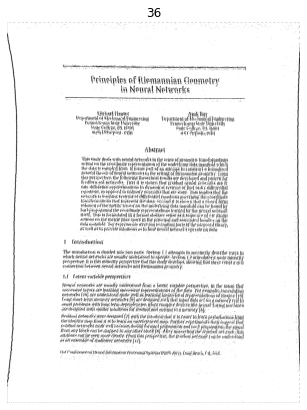

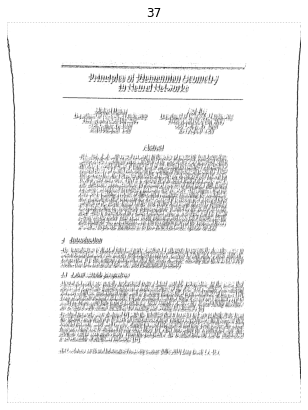

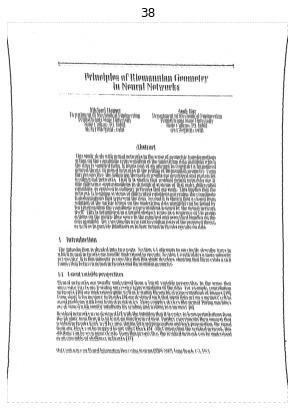

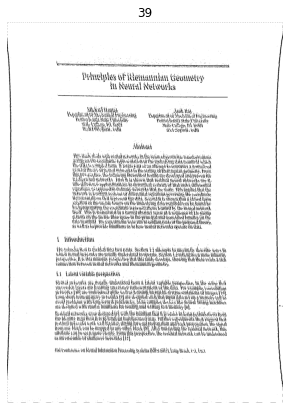

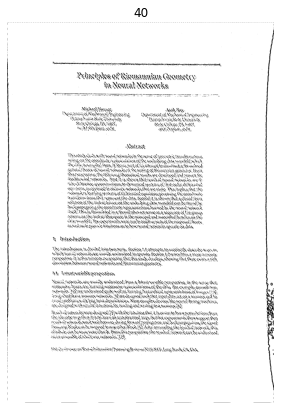

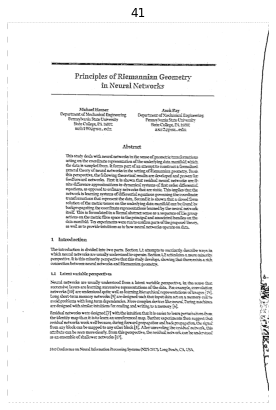

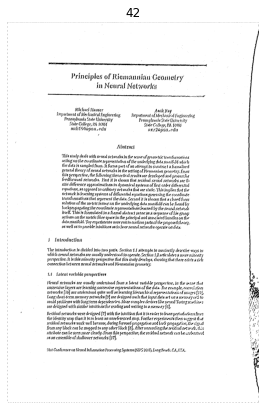

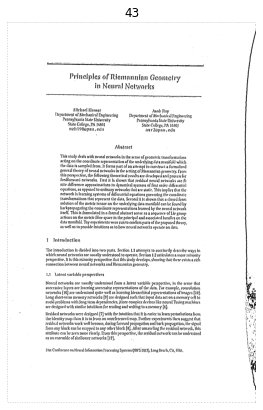

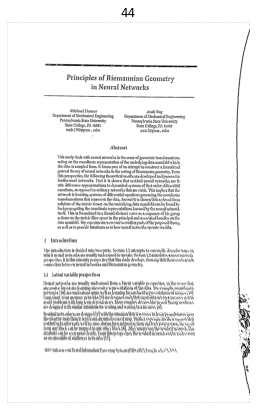

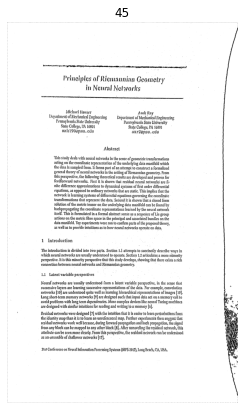

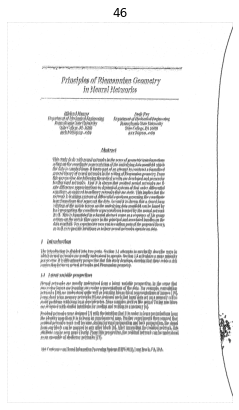

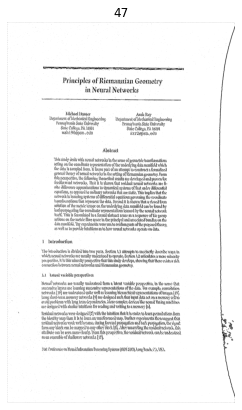

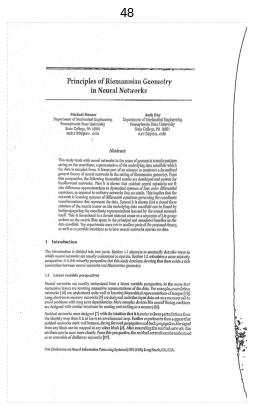

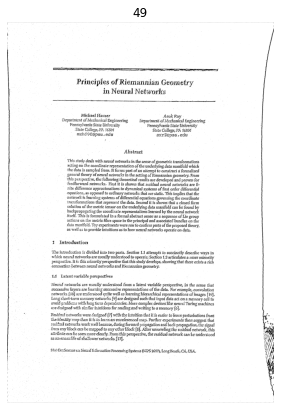

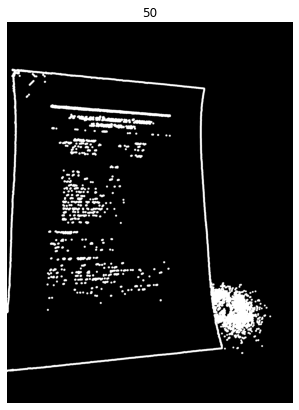

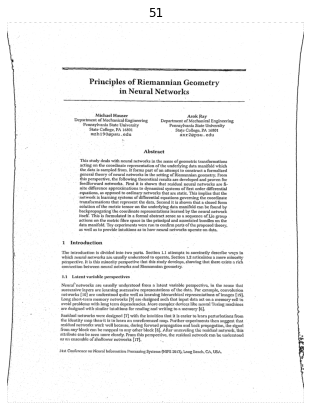

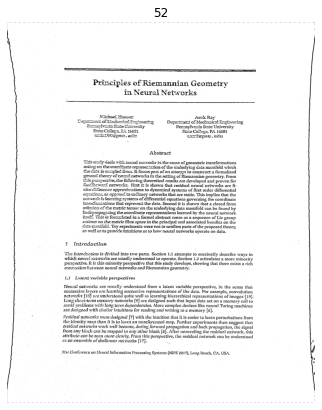

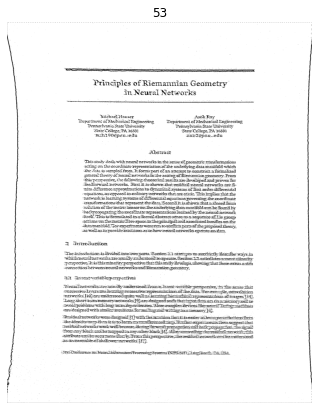

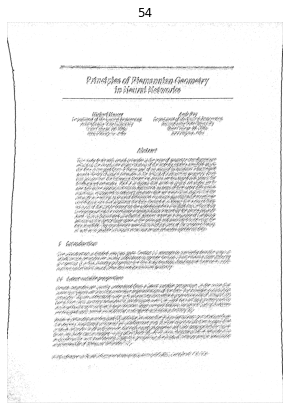

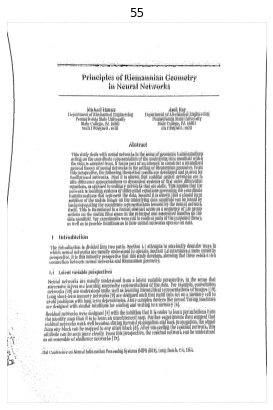

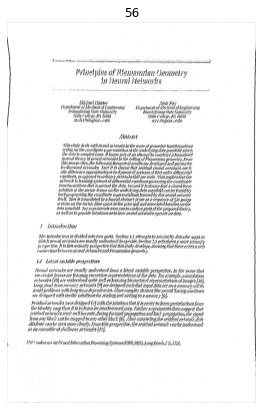

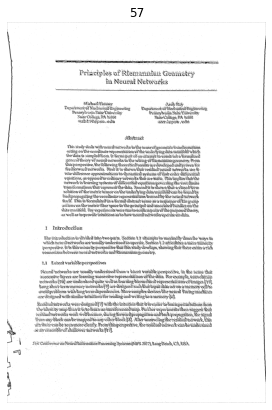

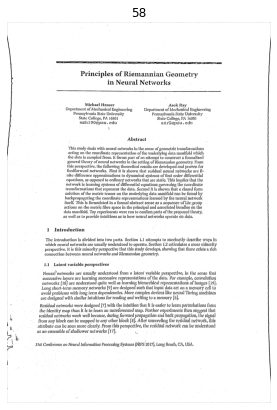

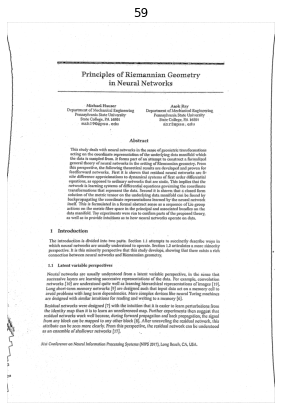

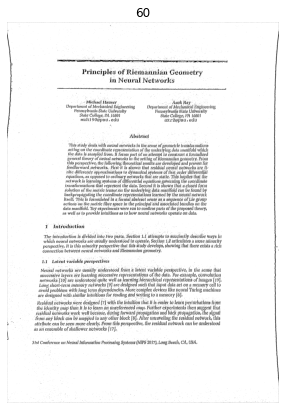

In [122]:
ls=[]
for i in range(1, 3):
    path = f'photos_project/0{str(i)}.jpg'
    ls.append((i, predict_image(cv2.imread(path))))
for i in range(11, 61):
    path = f'photos_project/{str(i)}.jpg'
    ls.append((i, predict_image(cv2.imread(path))))
    
render_images(ls)